# Train LBP+KNN, HOG+SVM, Mini-Xception Model

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import scikitplot.metrics as skplt


import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [3]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Import Training Data and Test Data From Fer2013

In [7]:
data = pd.read_csv('/Users/yuhaining/Desktop/FacialExpressionClassification/data/fer2013.csv')
print(data.shape)
data.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


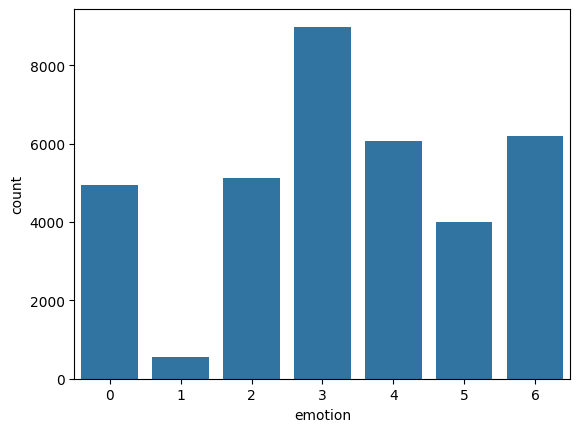

In [8]:
CLASSES = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

data.emotion.value_counts()
sns.countplot(x=data['emotion'])
plt.show()

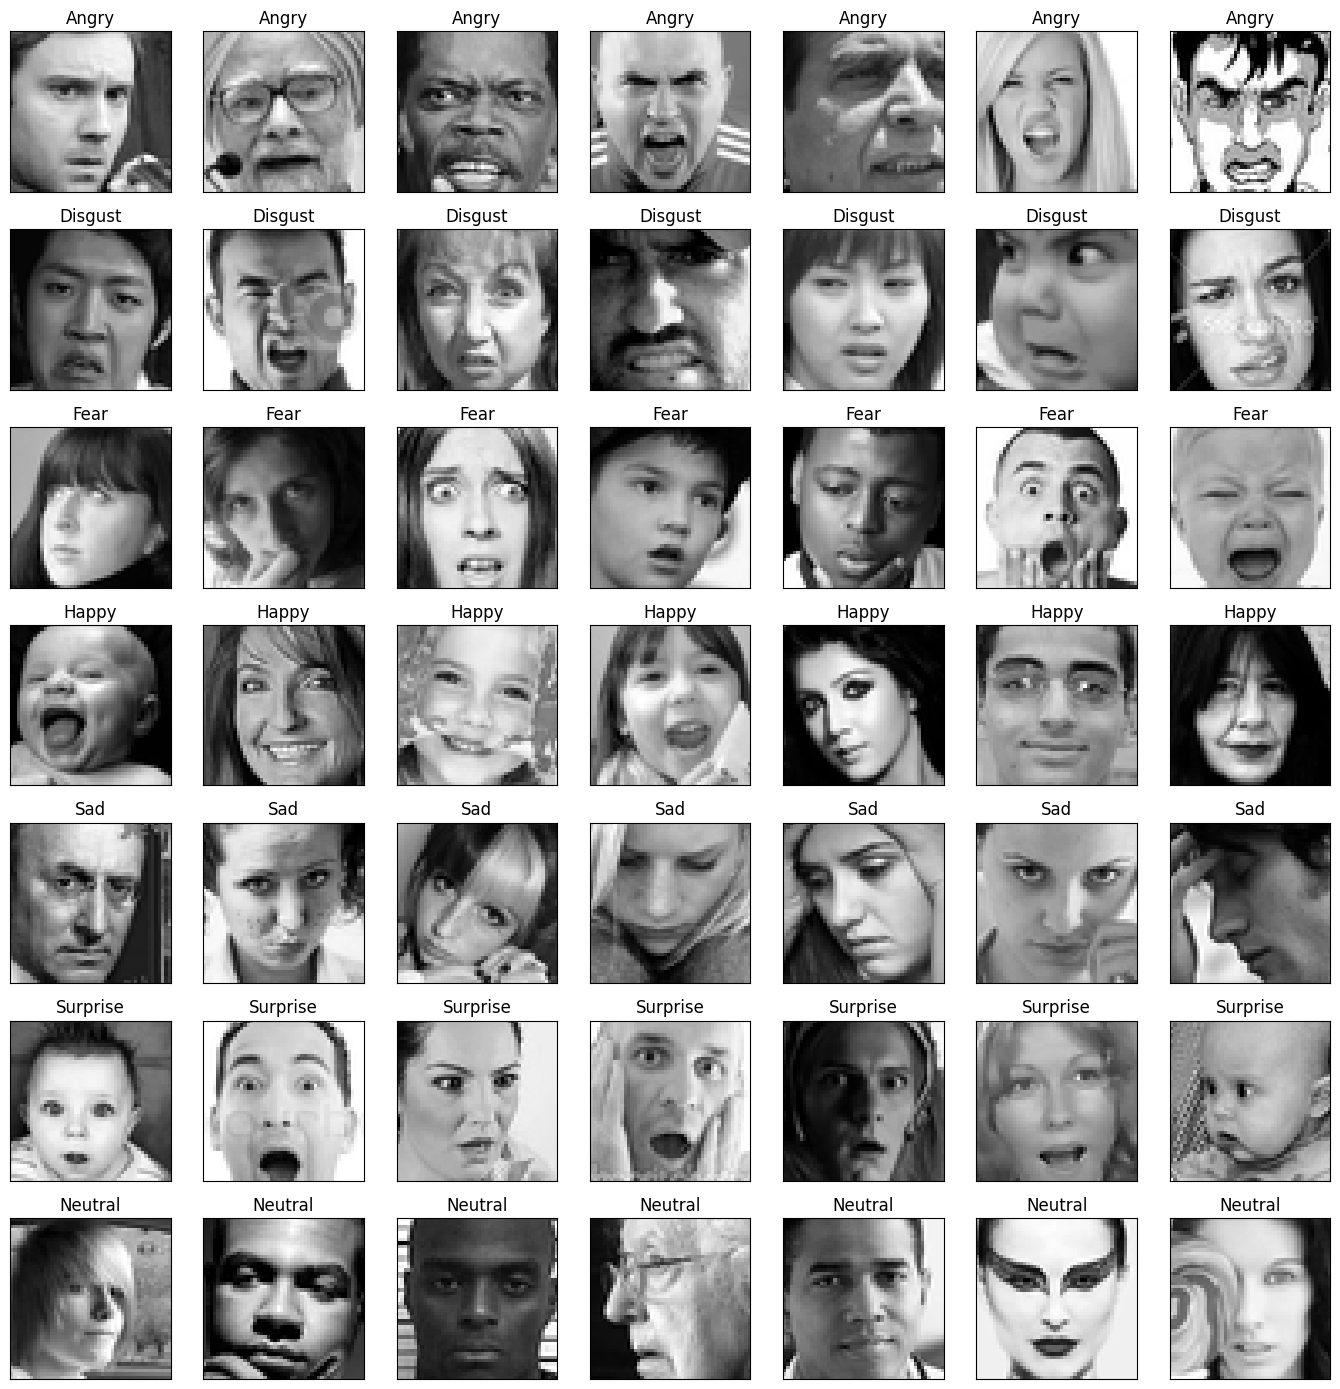

In [9]:
figure = pyplot.figure(1, figsize=(14,14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')

        k += 1
        ax = pyplot.subplot(7,7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(CLASSES[label])
        pyplot.tight_layout()

In [10]:
image_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48,48,1).astype('float32'))
image_array = np.stack(image_array, axis=0)
image_array.shape

(35887, 48, 48, 1)

In [11]:
image_labels = to_categorical(data.emotion, num_classes=7)
image_labels.shape

(35887, 7)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    image_array, image_labels, test_size=0.2, random_state=42, stratify=image_labels,shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709, 7), (7178, 7))

In [13]:
image_width = X_train.shape[1]
image_height = X_train.shape[2]
image_channels = X_train.shape[3]
num_classes = y_train.shape[1]

X_train = X_train / 255.0
X_test = X_test / 255.0

## Define and Train Mini-Xception Model

In [11]:
# Early Stopping and Learning Rate Scheduler
# to prevent overfitting and adjust learning rate during training
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1
)

callbacks = [
    early_stopping,
    lr_scheduler,
    checkpoint,
]

# Data Augmentation
# to artificially increase the size of the training dataset
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)


In [12]:
# Mini-XCEPTION Model Definition
def mini_xception(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(
        8, (3, 3), strides=(1, 1),
        kernel_regularizer=regularization,
        use_bias=False
    )(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(
        8, (3, 3), strides=(1, 1),
        kernel_regularizer=regularization,
        use_bias=False
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(
        16, (1, 1), strides=(2, 2),
        padding='same',
        use_bias=False
    )(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(
        16, (3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(
        16, (3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(
        32, (1, 1), strides=(2, 2),
        padding='same',
        use_bias=False
    )(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(
        32, (3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(
        32, (3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(
        64, (1, 1), strides=(2, 2),
        padding='same',
        use_bias=False
    )(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(
        64, (3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(
        64, (3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(
        128, (1, 1), strides=(2, 2),
        padding='same',
        use_bias=False
    )(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(
        128, (3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(
        128, (3, 3), padding='same'
    )(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # classifier
    x = Conv2D(num_classes, (3, 3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model

In [13]:
# Create and Compile Mini-XCEPTION Model
input_shape = (48, 48, 1)
num_classes = 7
model_xce = mini_xception(input_shape, num_classes)
model_xce.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_xce.summary()

2025-11-24 21:40:41.417847: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-11-24 21:40:41.417876: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-11-24 21:40:41.417879: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-11-24 21:40:41.417896: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-24 21:40:41.417905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 46, 46, 8) │         72 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 46, 46, 8) │         32 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 46, 46, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 44, 44, 8) │        576 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44, 8) │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 44, 44, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 44, 44,    │        216 │ activation_1[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 44, 44,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 44, 44,    │        416 │ activation_2[0][… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │         64 │ separable_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 22, 22,    │        128 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 22, 22,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 22,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 22, 22,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 22, 22,    │        688 │ add[0][0]         │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 58,903 (230.09 KB)

 Trainable params: 57,431 (224.34 KB)

 Non-trainable params: 1,472 (5.75 KB)

In [14]:
# Train Mini-XCEPTION Model
batch_size = 32
epochs = 100
history_xce = model_xce.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100


2025-11-24 21:40:42.688520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2525 - loss: 1.9396
Epoch 1: val_accuracy improved from None to 0.35651, saving model to best_model.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 94s 100ms/step - accuracy: 0.2914 - loss: 1.8400 - val_accuracy: 0.3565 - val_loss: 1.8315 - learning_rate: 0.0010
Epoch 2/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 1:28 99ms/step - accuracy: 0.2188 - loss: 1.9382

/opt/anaconda3/envs/DL/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.35651
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2188 - loss: 1.9382 - val_accuracy: 0.3537 - val_loss: 1.8457 - learning_rate: 0.0010
Epoch 3/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3842 - loss: 1.6246
Epoch 3: val_accuracy improved from 0.35651 to 0.41112, saving model to best_model.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 91s 101ms/step - accuracy: 0.3953 - loss: 1.5979 - val_accuracy: 0.4111 - val_loss: 1.6144 - learning_rate: 0.0010
Epoch 4/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 1:31 102ms/step - accuracy: 0.4062 - loss: 1.4303
Epoch 4: val_accuracy improved from 0.41112 to 0.41906, saving model to best_model.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4062 - loss: 1.4303 - val_accuracy: 0.4191 - val_loss: 1.5964 - learning_rate: 0.0010
Epoch 5/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4315 - loss: 1.5015
Epoch 5: val_accuracy improved from 0.41906 to 0.45918, saving model to best_

## Save Model

In [15]:
best_model = load_model("best_model.keras")
loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
print("Best model accuracy:", acc)

Best model accuracy: 0.6271942257881165


## Evaluate Model

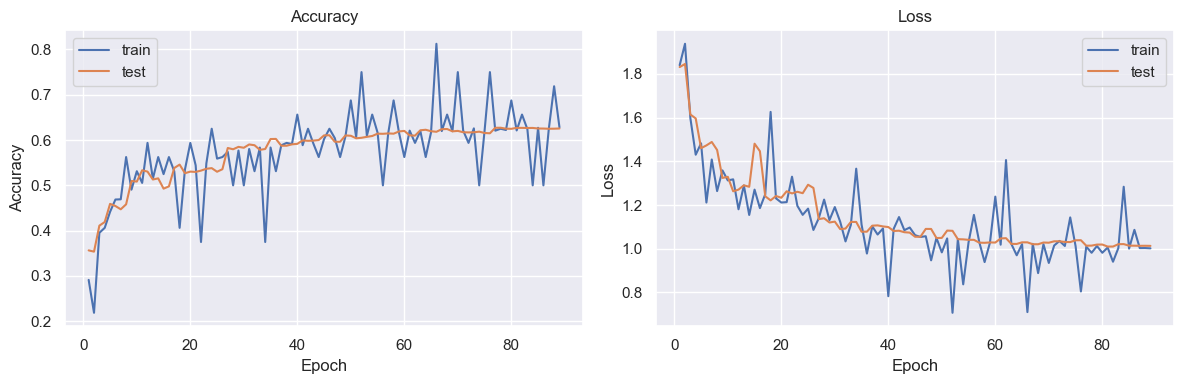

In [ ]:
sns.set()

epochs = range(1, len(history_xce.history['accuracy']) + 1)

fig = plt.figure(figsize=(12, 4))

# Accuracy curve
ax = plt.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=history_xce.history['accuracy'], label='train')
sns.lineplot(x=epochs, y=history_xce.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
ax = plt.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=history_xce.history['loss'], label='train')
sns.lineplot(x=epochs, y=history_xce.history['val_loss'], label='test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

<Figure size 700x700 with 0 Axes>

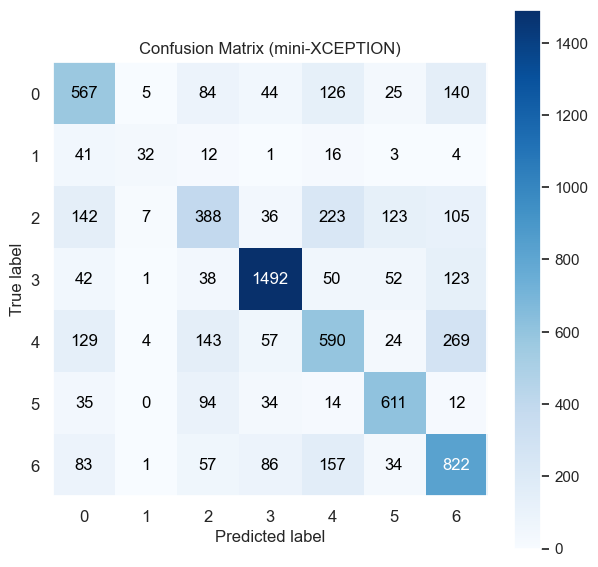

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       991
           1       0.64      0.29      0.40       109
           2       0.48      0.38      0.42      1024
           3       0.85      0.83      0.84      1798
           4       0.50      0.49      0.49      1216
           5       0.70      0.76      0.73       800
           6       0.56      0.66      0.61      1240

    accuracy                           0.63      7178
   macro avg       0.61      0.57      0.58      7178
weighted avg       0.63      0.63      0.62      7178



In [17]:

y_pred_prob = model_xce.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# confusion matrix
plt.figure(figsize=(7, 7))
skplt.plot_confusion_matrix(
    y_true,
    y_pred,
    normalize=False,
    figsize=(7,7),
)
plt.title("Confusion Matrix (mini-XCEPTION)")
plt.show()


# classification report
print(classification_report(y_true, y_pred))

In [15]:

model_xce = load_model("best_model.keras")
_ = model_xce.predict(X_test[:1])

start = time.time()
y_pred_prob = model_xce.predict(X_test, verbose=0)
end = time.time()

total_time = end - start
avg_latency = total_time / len(X_test)

print(f"Total inference time: {total_time:.4f} seconds")
print(f"Average latency per image: {avg_latency*1000:.4f} ms")

2025-11-25 22:48:29.669570: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-11-25 22:48:29.669687: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-11-25 22:48:29.669693: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-11-25 22:48:29.669715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-25 22:48:29.669728: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-25 22:48:30.284389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Total inference time: 1.6337 seconds
Average latency per image: 0.2276 ms
